In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.constants import R_sun, L_sun

import seaborn as sns
sns.set(font_scale=1.7, style='whitegrid', palette='dark', rc={'font.weight': 'medium'})

col = sns.color_palette()
lines = ['-', '--', '-.', ':', '-']

%matplotlib inline

## Part 1: Stellar Structure

### Read the MESA outputs to get the ZAMS properties of each star (at fixed solar metallicity).

In [2]:
zz = 'Z0.02' # fixed metallicity
mass = np.array((0.5, 1.0, 3.0, 8.0, 15.0))

massfile = ['M{:.1f}'.format(mm) for mm in mass]
solmass = np.where(mass == 1.0)[0][0] # index of the solar-mass star (used below)
mass5 = np.where(mass == 0.5)[0][0]
mass8 = np.where(mass == 8.0)[0][0]

nmodel = len(massfile)
zamsradius = np.zeros((nmodel)).astype('f4')
zamslum = np.zeros_like(zamsradius)
zamsmass = np.zeros_like(zamsradius)
zamsindx = np.zeros_like(zamsradius).astype('int') # time index of the ZAMS for each star
zamsprofile = np.ndarray((nmodel)).astype('<U')

for ii, mm in enumerate(massfile):
    ff = os.path.join(mm, zz, 'trimmed_history.data')
    print('Reading {}'.format(ff))
    cat = np.loadtxt(ff, skiprows=6)
    HI = cat[:, 10] 
    keep = np.where((HI[0] - HI) > 3E-3)[0]
    zamsindx[ii] = keep[0]

    zamsradius[ii] = cat[zamsindx[ii], 4]
    zamsmass[ii] = np.log10(cat[zamsindx[ii], 2])
    zamslum[ii] = cat[zamsindx[ii], 3]
    
    indexfile = os.path.join(mm, zz, 'profiles.index')
    model, profile = np.loadtxt(indexfile, skiprows=1, usecols=[0, 2], unpack=True)
    this = profile[(np.abs(model-zamsindx[ii])).argmin()].astype('int')
    
    zamsprofile[ii] = os.path.join(mm, zz, 'profile{:g}.data'.format(this)) # filename
    
massaxis = np.linspace(zamsmass.min()-0.1, zamsmass.max()+0.1, 50) # for the plots

Reading M0.5/Z0.02/trimmed_history.data
Reading M1.0/Z0.02/trimmed_history.data
Reading M3.0/Z0.02/trimmed_history.data
Reading M8.0/Z0.02/trimmed_history.data
Reading M15.0/Z0.02/trimmed_history.data


### Show and fit the ZAMS radius-mass and luminosity-mass scaling relations.

In [3]:
def mass_radius(pngfile=None):
    rcoeff = np.polyfit(zamsmass, zamsradius, 1)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.scatter(zamsmass, zamsradius, marker='s', s=100, color=col[:6])
    ax.plot(massaxis, np.polyval(rcoeff, massaxis), ls='--', lw=3,
            label=r'$R\propto M^{{{:.3f}}}$'.format(rcoeff[0]))
    ax.set_xlabel('$\log_{10}\ (M / M_{\odot})$')
    ax.set_ylabel('$\log_{10}\ (R / R_{\odot})$')
    ax.legend(loc='upper left', prop={'size': 22})
    if pngfile:
        fig.savefig(pngfile)

In [4]:
def mass_luminosity(pngfile=None):
    lcoeff = np.polyfit(zamsmass, zamslum, 1)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))            
    ax.scatter(zamsmass, zamslum, marker='s', s=100, color=col[:6])
    ax.plot(massaxis, np.polyval(lcoeff, massaxis), ls='--', lw=3,
            label=r'$L\propto M^{{{:.3f}}}$'.format(lcoeff[0]))
    ax.set_xlabel('$\log_{10}\ (M / M_{\odot})$')
    ax.set_ylabel('$\log_{10}\ (L / L_{\odot})$')
    ax.legend(loc='upper left', prop={'size': 22})
    if pngfile:
        fig.savefig(pngfile)

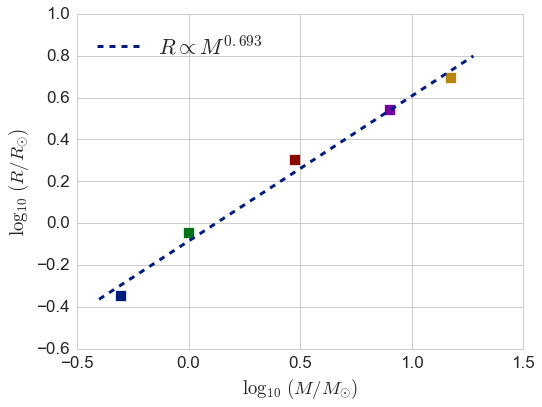

In [5]:
mass_radius('mass_radius.png')

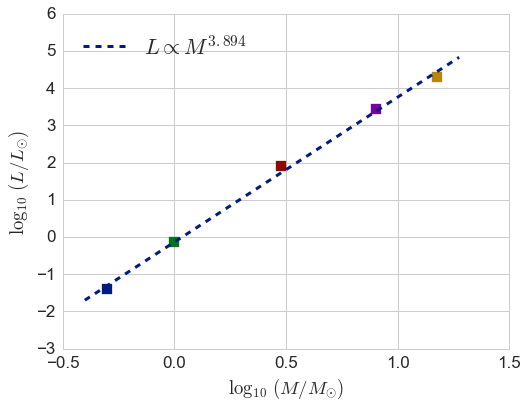

In [6]:
mass_luminosity('mass_luminosity.png')

### Investigate the structure of a 1 $M_{\odot}$ ZAMS star (comparing against 0.5 and 8 $M_{\odot}$ ZAMS stars where needed).

#### $M = 1M_{\odot}$

In [7]:
soldata = np.loadtxt(zamsprofile[solmass], skiprows=6)
profradius = soldata[:, 1] / soldata[0, 1] # normalized radius
profmass = soldata[:, 0]
profdens = 10**soldata[:, 4] * 1E3 # kg/m3
proftemp = 10**soldata[:, 5] # convert to linear temperature
proflum = soldata[:, 2] / soldata[0, 2] # normalized luminosity

presstot = soldata[:, 3] * 0.1 # total pressure (N/m2)
pressgas = soldata[:, 13] * 0.1 # gas pressure
pressrad = soldata[:, 14] * 0.1 # radiation pressure

etot = soldata[:, 19] * 1E-4 # total energy generation rate [J/kg/s]
epp = soldata[:, 20] * 1E-4 # pp chain
ecno = soldata[:, 21] * 1E-4 # CNO cycle
e3a = soldata[:, 22] * 1E-4 # triple-alpha process

nabla_ad = soldata[:, 10] # adiabatic condition
nabla_rad = soldata[:, 15] # radiative gradient

XHI = soldata[:, 26] # hydrogen mass fraction
XHe4 = soldata[:, 27] # helium mass fraction

#### $M = 0.5M_{\odot}$

In [8]:
data5 = np.loadtxt(zamsprofile[mass5], skiprows=6)
radius5 = data5[:, 1] / data5[0, 1] # normalized radius
presstot5 = data5[:, 3] * 0.1 # total pressure (N/m2)
pressgas5 = data5[:, 13] * 0.1 # gas pressure
pressrad5 = data5[:, 14] * 0.1

#### $M = 8M_{\odot}$

In [9]:
data8 = np.loadtxt(zamsprofile[mass8], skiprows=6)
radius8 = data8[:, 1] / data8[0, 1] # normalized radius

nabla8_ad = data8[:, 10] # adiabatic condition
nabla8_rad = data8[:, 15] # radiative gradient

In [10]:
def sun_density_mass(pngfile):
    '''Density and enclosed mass.'''
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(profradius, profdens / 1E4)
    ax1.set_xlabel(r'$r\ /\ R$')
    ax1.set_ylabel(r'$\rho\ (10^{4}\ kg\ m^{-3})$')
    ax1.annotate(r'$\rho(r)$', xy=(0.15, 6.5), xycoords='data', 
                 fontsize=22, ha='left', color=col[0])
    ax1.annotate(r'$M = 1\ M_{\odot}$', xy=(0.85, 0.3), fontsize=22, 
                 ha='right', va='center', xycoords='figure fraction')

    ax2 = ax1.twinx()
    ax2.plot(profradius, profmass, ls='--', color=col[1])
    ax2.set_ylim(0, 1.01)
    ax2.grid(False)
    ax2.set_ylabel(r'$M\ /\ M_{\odot}$')
    ax2.annotate(r'$M(r)$', xy=(0.7, 0.85), xycoords='data', 
                 fontsize=22, ha='left', color=col[1])
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.87)
    if pngfile:
        fig.savefig(pngfile)

In [11]:
def sun_pressure(pngfile, scale=1E16):
    '''Pressure profiles.'''
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(profradius, pressgas / scale, label=r'$P_{gas}$', ls=lines[0])
    ax1.plot(profradius, pressrad / scale * 100, label=r'$P_{rad}\times100$', ls=lines[1])
    ax1.set_xlabel(r'$r\ /\ R$')
    ax1.set_ylabel(r'$P_{tot}\ (10^{16}\ N\ m^{-2})$')
    ax1.legend(loc='upper right')
    ax1.annotate(r'$M = 1.0 M_{\odot}$', xy=(0.85, 0.3), 
                 fontsize=22, ha='right', xycoords='figure fraction')
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [12]:
def sun_luminosity(pngfile, scale=1.0):
    '''Luminosity profile.'''
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(profradius, proflum * scale)
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel(r'$r\ /\ R$')
    ax1.set_ylabel(r'$L\ /\ L_{tot}$')
    ax1.axhline(1.0, ls='--', color=col[2])
    ax1.annotate(r'$M = 1\ M_{\odot}$', xy=(0.85, 0.3), fontsize=22, 
                 ha='right', va='center', xycoords='figure fraction')
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [13]:
def sun_epsilon(pngfile, scale=1E-3):
    '''Energy generation rate'''
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(profradius, etot / scale, label=r'Total', ls=lines[0])
    ax1.plot(profradius, epp / scale, label='pp chain', ls=lines[1])
    ax1.plot(profradius, ecno / scale, label='CNO cycle', ls=lines[2])
    ax1.plot(profradius, e3a / scale, label=r'3$\alpha$ process', ls=lines[3])
    ax1.legend()
    ax1.set_xlim(0, 0.6)
    ax1.set_xlabel(r'$r\ /\ R$')
    ax1.set_ylabel(r'$\epsilon \ (10^{3}\ J\ kg^{-1}\ s^{-1})$')
    ax1.annotate(r'$M = 1\ M_{\odot}$', xy=(0.85, 0.3), fontsize=22, 
                 ha='right', va='center', xycoords='figure fraction')
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [14]:
def sun_temperature(pngfile, scale=1E7):
    '''Temperature gradient'''
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(profradius, proftemp / scale)
    ax1.set_xlabel(r'$r\ /\ R$')
    ax1.set_ylabel(r'$T\ (10^{7}\ K)$')
    ax1.annotate(r'$M = 1\ M_{\odot}$', xy=(0.85, 0.85), fontsize=22, 
                 ha='right', va='center', xycoords='figure fraction')
    ax1.annotate('$Kink!$', xy=(0.72, 0.25), xytext=(0.85, 0.65), fontsize=18, 
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
                 ha='center', va='center', xycoords='data')
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [15]:
def transport_lowmass_highmass(pngfile=None, scale=1.0):
    '''Nabla for M=1.0 and M=8.0 stars.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    ax1.plot(profradius, nabla_ad * scale, label=r'$\nabla_{ad}$')
    ax1.plot(profradius, nabla_rad * scale, label=r'$\nabla_{rad}$', ls='--')
    ax1.set_ylim(0, 1.8)
    ax1.legend(loc='upper left')
    ax1.set_xlabel(r'$r\ /\ R$')
    ax1.set_ylabel(r'$\nabla$')
    ax1.annotate(r'$M = 1 M_{\odot}$', xy=(0.3, 0.5), fontsize=22, 
                 ha='right', va='center', xycoords='figure fraction')
    ax1.annotate('Radiative Zone', xy=(0.4, 0.3), fontsize=14, 
                 ha='center', va='center', xycoords='data')
    ax1.annotate('Convective Zone', xy=(0.9, 0.9), fontsize=14, 
                 ha='center', va='center', xycoords='data',
                 rotation=90)

    ax2.plot(radius8, nabla8_ad * scale, label=r'$\nabla_{ad}$')
    ax2.plot(radius8, nabla8_rad * scale, label=r'$\nabla_{rad}$', ls='--')
    ax2.set_ylim(0, 1.8)
    ax2.annotate('Radiative Zone', xy=(0.5, 0.3), fontsize=14, 
                 ha='center', va='center', xycoords='data')
    ax2.annotate('Convective Zone', xy=(0.05, 0.9), fontsize=14, 
                 ha='center', va='center', xycoords='data',
                 rotation=90)
    ax2.legend()
    ax2.set_xlabel(r'$r\ /\ R$')
    ax2.annotate(r'$M = 8 M_{\odot}$', xy=(0.85, 0.5), fontsize=22, 
                 ha='right', va='center', xycoords='figure fraction')
    fig.subplots_adjust(wspace=0.08, bottom=0.2, left=0.08, right=0.98, top=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [16]:
def sun_pressure_lowmass(pngfile=None, scale=1E16):
    '''Pressure profiles - don't use these because they don't include degeneracy pressure.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    ax1.plot(profradius, pressgas / scale, label=r'$P_{gas}$')
    ax1.plot(profradius, pressrad / scale * 100, label=r'$P_{rad}\times100$')
    ax1.set_xlabel(r'$R\ /\ R_{\odot}$')
    ax1.set_ylabel(r'$P_{tot}\ (10^{16}\ N\ m^{-2})$')
    ax1.legend(loc='upper right')
    ax1.annotate(r'$M = 1.0 M_{\odot}$', xy=(0.45, 0.3), 
                 fontsize=22, ha='right', xycoords='figure fraction')

    ax2.plot(radius5, pressgas5 / 1E16, label=r'$P_{gas}$')
    ax2.set_xlabel(r'$R\ /\ R_{\odot}$')
    ax2.legend(loc='upper right')
    ax2.annotate(r'$M = 0.5 M_{\odot}$', xy=(0.92, 0.3), 
                 fontsize=22, ha='right', xycoords='figure fraction')
    fig.subplots_adjust(wspace=0.08)
    if pngfile:
        fig.savefig(pngfile)

In [17]:
def sun_composition(pngfile):
    '''Hydrogen and helium composition.'''
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ax1.plot(profradius, XHI, label=r'H')
    ax1.plot(profradius, XHe4, label=r'He')
    ax1.set_xlabel(r'$r\ /\ R$')
    ax1.set_ylabel('Mass Fraction')
    ax1.set_ylim(0, 1)
    ax1.legend(loc='upper right')
    ax1.annotate(r'$M = 1\ M_{\odot}$', xy=(0.85, 0.85), fontsize=22, 
                 ha='right', va='center', xycoords='figure fraction')
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

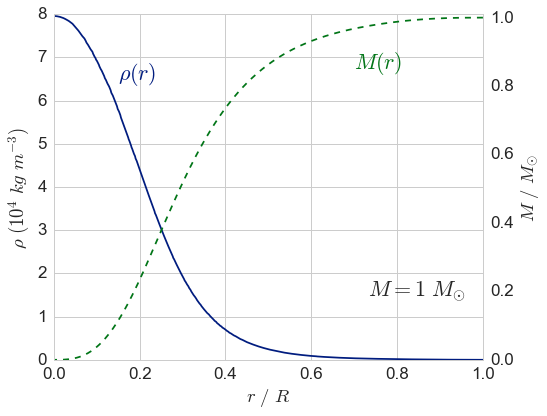

In [18]:
sun_density_mass('sun_density_mass.png')

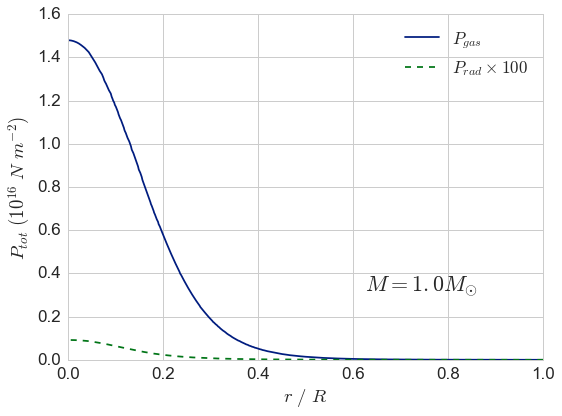

In [19]:
sun_pressure('sun_pressure.png')

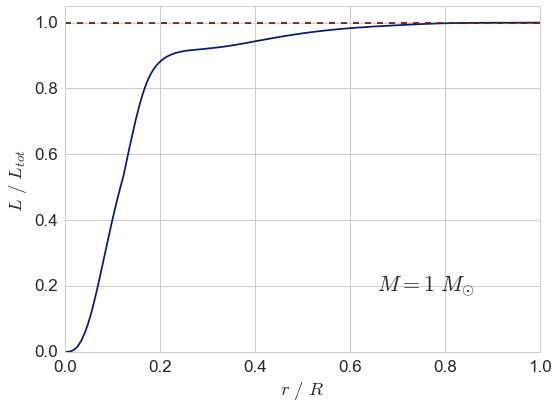

In [20]:
sun_luminosity('sun_luminosity.png')

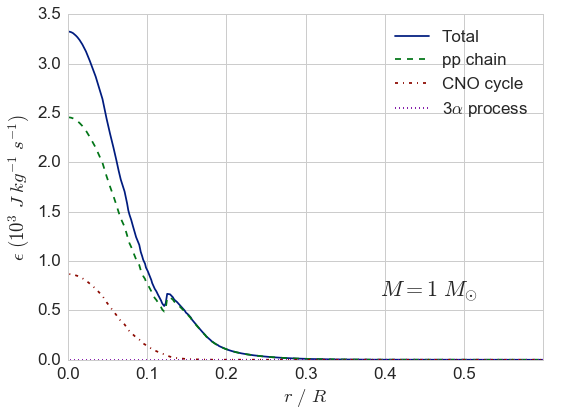

In [21]:
sun_epsilon('sun_epsilon.png')

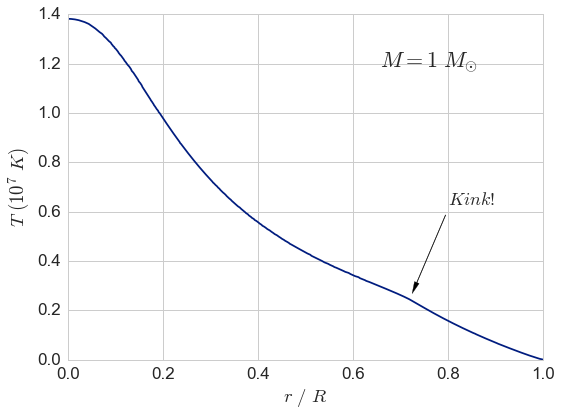

In [22]:
sun_temperature('sun_temperature.png')

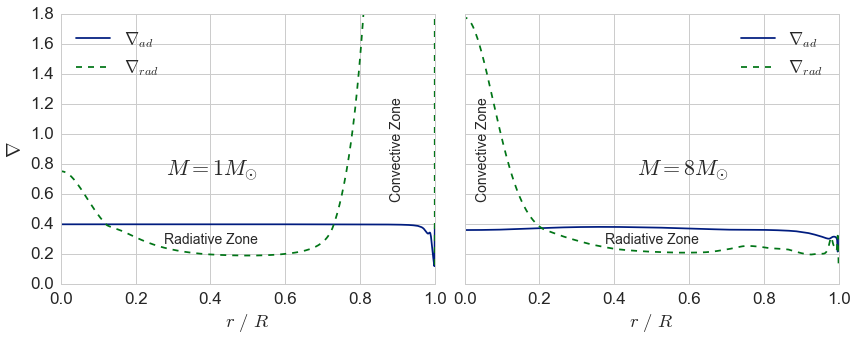

In [23]:
transport_lowmass_highmass('transport_lowmass_highmass.png')

In [24]:
# For this plot to be meaningful I need to read the ~5 Gyr profile file, not the ZAMS one...
# sun_composition('sun_composition.png')

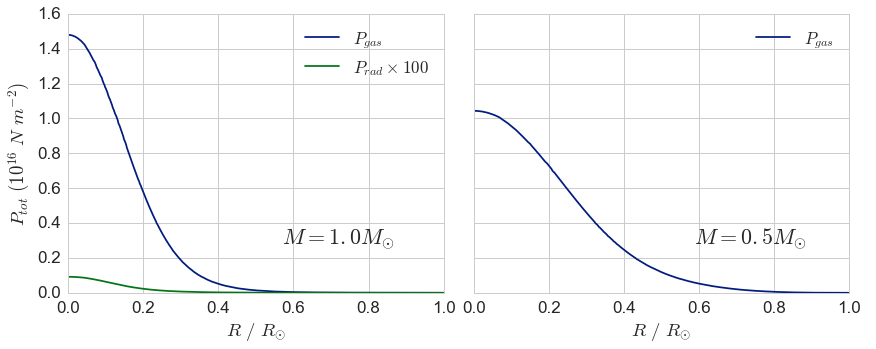

In [25]:
sun_pressure_lowmass()

### Compare the radial profiles of various physical quantities for all five stars.

In [26]:
def temperature_5models(pngfile=None, scale=1E7):
    '''Temperature gradient for all 5 stars.'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for ii, mm in enumerate(mass):
        data = np.loadtxt(zamsprofile[ii], skiprows=6)
        radius = data[:, 1] / data[0, 1] # normalize to the outer radius
        temp = 10**data[:, 5] # convert to linear temperature
        ax.plot(radius, temp / scale, ls=lines[ii],
                label='${:g} M_{{\odot}}$'.format(mm))
    ax.set_xlabel(r'$r\ /\ R$')
    ax.set_ylabel(r'$T\ (10^{7}\ K)$')
    ax.legend()
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [27]:
def density_5models(pngfile=None, scale=1E4):
    '''Density gradient for all 5 stars.'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for ii, mm in enumerate(mass):
        data = np.loadtxt(zamsprofile[ii], skiprows=6)
        radius = data[:, 1] / data[0, 1] # normalize to the outer radius
        density = 10**data[:, 4]  * 1E3 # kg/m3 
        ax.plot(radius, density / scale, ls=lines[ii], 
                label='${:g} M_{{\odot}}$'.format(mm))
    ax.set_xlabel(r'$r\ /\ R$')
    ax.set_ylabel(r'$\rho\ (10^{4}\ kg\ m^{-3})$')
    ax.legend()
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [28]:
def pressure_5models(pngfile=None, scale=1E16):
    '''Total pressure gradient for all 5 stars.'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for ii, mm in enumerate(mass):
        data = np.loadtxt(zamsprofile[ii], skiprows=6)
        radius = data[:, 1] / data[0, 1] # normalize to the outer radius
        ptot = data[:, 3] * 0.1 # convert from dyne/cm2 --> N/m2
        ax.plot(radius, ptot / scale, ls=lines[ii],
                label='${:g} M_{{\odot}}$'.format(mm))
    ax.set_xlabel(r'$r\ /\ R$')
    ax.set_ylabel(r'$P_{tot}\ (10^{16}\ N\ m^{-2})$')
    ax.legend()
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [29]:
def beta_5models(pngfile=None, scale=1.0):
    '''Ratio of the radiation to gas pressure gradient for all 5 stars.'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for ii, mm in enumerate(mass):
        data = np.loadtxt(zamsprofile[ii], skiprows=6)
        radius = data[:, 1] / data[0, 1] # normalize to the outer radius
        prad = data[:, 14] * 0.1 # radiation pressure (dyne/cm2 --> N/m2)
        pgas = data[:, 13] * 0.1 # gas pressure (dyne/cm2 --> N/m2)
        beta = prad / pgas
        ax.plot(radius, beta, ls=lines[ii],
                label='${:g} M_{{\odot}}$'.format(mm))
    ax.semilogy()
    ax.set_ylim(1E-6, 1.0)
    ax.set_xlabel(r'$r\ /\ R$')
    ax.set_ylabel(r'$\beta\equiv P_{rad} / P_{gas}$')
    ax.legend(loc='lower left', ncol=3)
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [30]:
def epsilon_5models(pngfile=None, scale=1E-3):
    '''Energy generation rate 3 representative stars (1, 3, 8 Msun).'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for ii, indx in enumerate((1, 2, 3)):
        data = np.loadtxt(zamsprofile[indx], skiprows=6)
        radius = data[:, 1] / data[0, 1] # normalize to the outer radius
        etot = data[:, 19] * 1E-4 # total energy generation rate [J/kg/s]
        epp = data[:, 20] * 1E-4 # pp chain
        ecno = data[:, 21] * 1E-4 # CNO cycle
        e3a = data[:, 22] * 1E-4 # triple-alpha process  -- this is ~zero on the ZAMS
        ax.plot(radius, etot / scale, ls=lines[0], color=col[ii], label='Total')
        ax.plot(radius, epp / scale, ls=lines[1], color=col[ii], label='pp chain')
        ax.plot(radius, ecno / scale, ls=lines[2], color=col[ii], label='CNO cycle')
        #ax.plot(radius, e3a / scale, ls=lines[3], color=col[ii], label=r'$3\alpha$ process')
    ax.semilogy()
    ax.set_ylim(1E-3, 1E4)
    ax.set_xlabel(r'$r\ /\ R$')
    ax.set_ylabel(r'$\epsilon \ (10^{-3}\ J\ kg^{-1}\ s^{-1})$')
    ax.set_xlim(0, 0.5)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:4], labels[:3], loc='upper right')
              #labels=['Total', 'pp chain', 'CNO cycle', '$3\alpha$ process'])
    leg = ax.get_legend()
    [leg.legendHandles[jj].set_color('gray') for jj in range(3)]

    ax.annotate(r'$1\ M_{\odot}$', xy=(0.05, 0.1), fontsize=22, color=col[0],
                 ha='center', va='center', xycoords='data')
    ax.annotate(r'$3\ M_{\odot}$', xy=(0.05, 200), fontsize=22, color=col[1],
                 ha='center', va='center', xycoords='data')
    ax.annotate(r'$8\ M_{\odot}$', xy=(0.15, 2000), fontsize=22, color=col[2],
                 ha='center', va='center', xycoords='data')
    
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    if pngfile:
        fig.savefig(pngfile)

In [31]:
def temperature_pressure_5models(pngfile=None):
    '''
    This is a version of the previous two functions with the 
    temperature and pressure shown in a single figure.
    '''
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    for ii, mm in enumerate(mass):
        data = np.loadtxt(zamsprofile[ii], skiprows=6)
        profradius = data[:, 1] / data[0, 1] # normalize to the outer radius
        proftemp = 10**data[:, 5] # convert to linear temperature
        profpressure = data[:, 3] * 0.1 # convert from dyne/cm2 --> N/m2
        ax[0].plot(profradius, proftemp / 1E7, ls=lines[ii], 
                   label='${:g} M_{{\odot}}$'.format(mm))
        ax[1].plot(profradius, profpressure / 1E16, ls=lines[ii], 
                   label='${:g} M_{{\odot}}$'.format(mm))
    ax[0].set_xlabel(r'$r\ /\ R$')
    ax[0].set_ylabel(r'$T\ (10^{7}\ K)$')
    ax[0].legend()
    ax[1].set_xlabel(r'$r\ /\ R$')
    ax[1].set_ylabel(r'$P_{tot}\ (10^{16}\ N\ m^{-2})$')
    ax[1].legend()
    if pngfile:
        fig.savefig(pngfile)

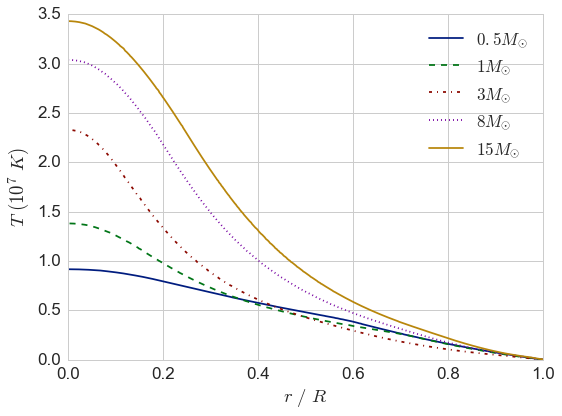

In [32]:
temperature_5models('temperature_5models.png')

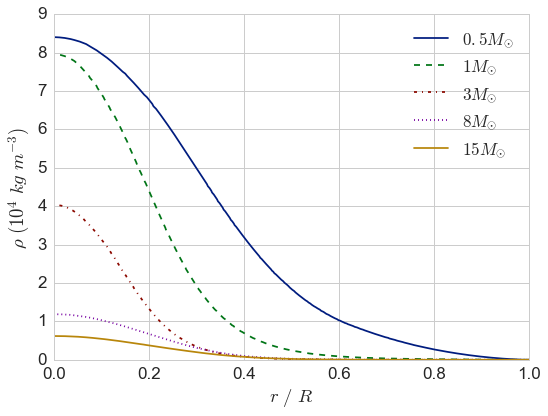

In [33]:
density_5models('density_5models.png')

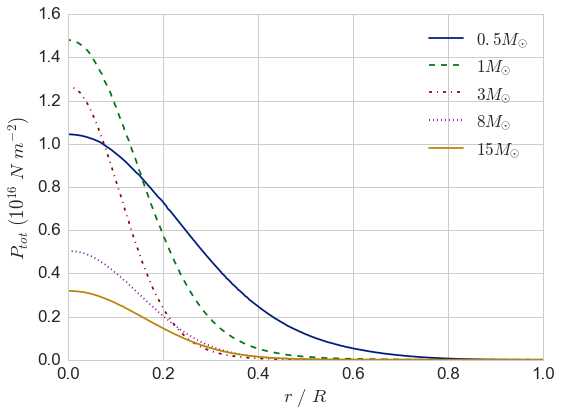

In [34]:
pressure_5models('pressure_5models.png')

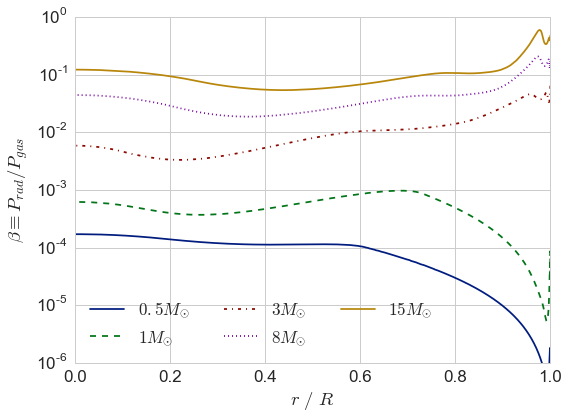

In [35]:
beta_5models('beta_5models.png')

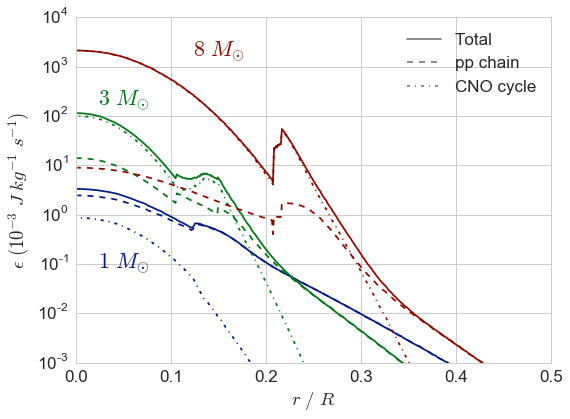

In [36]:
epsilon_5models('epsilon_5models.png')

In [37]:
#temperature_pressure_5models('temperature_pressure_5models.png')